In [131]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [158]:
orders = pd.read_csv('../seed/orders_pre.csv')
print(orders[0:2])
print('length: ' + str(len(orders)))

       order_id  customer_id  order_date order_type order_status  \
0  12069-4TMV42        12069  2017/08/23     Online      Shipped   
1  11239-0LHH93        11239  2020/06/14     Retail    Completed   

   shipping_amount  product_id  price  quantity  
0            17.54         230  72.75         1  
1            15.85         240  26.50         1  
length: 1000


In [168]:
new_orders = orders.copy()
new_orders.insert(loc=6, column='order_line_id', value=orders['order_id']+"-1")
n = len(orders)
line = 1
for i, row in orders.iterrows():
    if (i + 1) == n: 
        break
    r = random.randint(0,1)
    if  r == 0:
        line = 1
        cur_row = row
    else:
        if line == 1:
            cur_row = row
        line = line + 1
        new_orders.iloc[i+1,0:6] = cur_row[0:6]
        new_orders.loc[i+1, 'order_line_id'] = cur_row['order_id']+"-"+str(line)
        

In [169]:
new_orders.head(n=20)

,order_id,customer_id,order_date,order_type,order_status,shipping_amount,order_line_id,product_id,price,quantity
0,12069-4TMV42,12069,2017/08/23,Online,Shipped,17.54,12069-4TMV42-1,230,72.75,1
1,12069-4TMV42,12069,2017/08/23,Online,Shipped,17.54,12069-4TMV42-2,240,26.50,1
2,10648-2LJO58,10648,2018/11/26,Online,Shipped,15.46,10648-2LJO58-1,130,29.76,1
3,12172-1FWV29,12172,2020/10/05,Retail,Completed,11.46,12172-1FWV29-1,310,32.34,1
4,12172-1FWV29,12172,2020/10/05,Retail,Completed,11.46,12172-1FWV29-2,150,20.14,1
5,12287-0QYI21,12287,2020/12/04,Online,Shipped,10.43,12287-0QYI21-1,310,32.34,1
6,11605-3INI74,11605,2017/05/15,Online,Shipped,7.42,11605-3INI74-1,320,65.34,1
7,12734-5RPF16,12734,2019/10/15,Online,Shipped,8.32,12734-5RPF16-1,410,276.00,1
8,12734-5RPF16,12734,2019/10/15,Online,Shipped,8.32,12734-5RPF16-2,140,22.77,1
9,12734-5RPF16,12734,2019/10/15,Online,Shipped,8.32,12734-5RPF16-3,120,33.12,1


In [170]:
new_orders.groupby('order_type')['customer_id'].count()

order_type
Online    746
Retail    254
Name: customer_id, dtype: int64

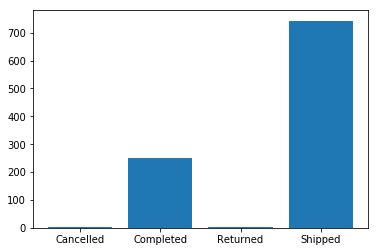

In [171]:
plt.clf()
plt.bar(np.sort(new_orders['order_status'].unique()),new_orders.groupby('order_status')['order_id'].count())
plt.show()

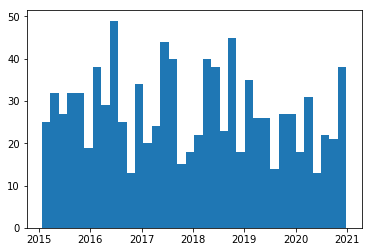

In [172]:
df = pd.DataFrame(pd.to_datetime(new_orders['order_date']))
plt.hist(df['order_date'], 36)
plt.show()

In [173]:
new_orders.to_csv('../seed/orders_new.csv', encoding='utf-8', index=False)